In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import igraph as ig
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
# path = r"C:\Users\yangs\Downloads\games_rm_4v4_s6.json.gz"

# game_data = pd.read_json(path)
# game_data_copy = game_data.explode("teams").explode("teams")

# team_data = pd.json_normalize(game_data_copy["teams"])

# game_data_copy_reindex = game_data_copy.reset_index(drop = True)
# game_data_copy_reindex["index"] = game_data_copy_reindex.index


# team_data["index"] = team_data.index

# keep_var = ["game_id", "started_at", "finished_at", "server", "patch", "profile_id", "result", "civilization", "mmr"]

# df = pd.merge(game_data_copy_reindex.drop(columns = "teams"), team_data, how = "inner").loc[:, keep_var]

# df.to_csv(r"C:\Users\yangs\Downloads\games_rm_4v4_s6.csv")

In [3]:
#a function that reads the dataset
def read_game_data(path):
    game_data = pd.read_json(path)
    game_data_copy = game_data.explode("teams").explode("teams")
    
    team_data = pd.json_normalize(game_data_copy["teams"])
    #after slicing, the index remains, so reset_index is needed. without "drop = True", we get two new columns of indices 
    team_0 = team_data[0: :2].reset_index(drop = True).add_suffix("_0")
    team_1 = team_data[1: :2].reset_index(drop = True).add_suffix("_1")
    #binds the sliced df together
    dataset = pd.concat([game_data.drop(columns="teams"), team_0, team_1], axis = 1)
    dataset["started_at"] = pd.to_datetime(dataset["started_at"])
    dataset["finished_at"] = pd.to_datetime(dataset["finished_at"])
    dataset.sort_values(by = "started_at")
    dataset = dataset.drop(columns = "map_id")
    dataset = dataset.rename(columns = {"profile_id_0": "player_0", 
                              "profile_id_1": "player_1", 
                              "civilization_1": "civ_1", 
                              "civilization_0": "civ_0", 
                              "civilization_randomized_0": "rand_civ_0", 
                              "civilization_randomized_1": "rand_civ_1"})
    return(dataset)

def map_player_ids(df, player_col_1, player_col_2):
    """
    Maps player IDs in a DataFrame to unique consecutive integers.

    Parameters:
    df (pd.DataFrame): DataFrame containing player match data.
    player_col_1 (str): Name of the first player column.
    player_col_2 (str): Name of the second player column.

    Returns:
    dict: A dictionary mapping player IDs to unique consecutive integers.
    list: A list of tuples representing the mapped edge list.
    """
    # Get unique players in the DataFrame
    unique_players = pd.unique(df[[player_col_1, player_col_2]].values.ravel())

    # Create a mapping from player IDs to consecutive integers
    player_id_to_index = {player_id: index for index, player_id in enumerate(unique_players)}

    # Map the player IDs in the edge list to consecutive integers
    mapped_edges = [(player_id_to_index[row[player_col_1]], player_id_to_index[row[player_col_2]]) for _, row in df.iterrows()]

    return player_id_to_index, mapped_edges



In [4]:
#load the dataset
# path = r"C:\Users\yangs\Downloads\games_qm_1v1_2023_q2.json\games_qm_1v1_2023_q2.json"
# path = r"C:\Users\yangs\Downloads\games_rm_1v1_s5.json\games_rm_1v1_s5.json"
# dataset = read_game_data(path)

# dataset.to_csv(r"C:\Users\yangs\Desktop\games_rm_1v1_s5.csv")

dataset = pd.read_csv(r"C:\Users\yangs\Desktop\games_rm_1v1_s5.csv").drop(columns = "Unnamed: 0")

In [5]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server", "mmr_0", "mmr_1"]].dropna(axis= 0 )

temp = temp[temp["started_at"].between("2023-06-16", "2023-08-16")]

p1 = temp.loc[:,["player_0", "mmr_0"]].rename(columns = {"player_0": "Player_ID", "mmr_0": "MMR"})
p2 = temp.loc[:, ["player_1", "mmr_1"]].rename(columns = {"player_1": "Player_ID", "mmr_1": "MMR"})
player = pd.concat([p1, p2]).groupby("Player_ID").agg(Mean_MMR = ("MMR", "mean"), Game_Count = ("MMR", "count")).reset_index()

group_0 = player[player["Mean_MMR"].between(800, 900)].copy()
group_0["Group"] = 0
group_1 = player[player["Mean_MMR"].between(1000, 1100)].copy()
group_1["Group"] = 1
# group_2 = player[player["Mean_MMR"].between(1200, 1300)].copy()
# group_2["Group"] = 2

# selected_players = pd.concat([group_0, group_1, group_2])
selected_players = pd.concat([group_0, group_1])

selected_players = selected_players[selected_players["Game_Count"] > 30].copy()

In [6]:
selected_0 = selected_players["Player_ID"].tolist()
edge_0 = temp[temp["player_0"].isin(selected_0) & temp["player_1"].isin(selected_0)].loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(edge_0, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)
A0 = torch.Tensor(g.get_adjacency().data)

selected_players["Graph_ID"] = [player_id_to_index[player_id] for player_id in selected_players["Player_ID"]]

In [7]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server", "mmr_0", "mmr_1"]].dropna(axis= 0 )
temp_1 = temp[temp["started_at"].between("2023-08-17", "2023-10-17")]

edge_1 = temp_1[temp_1["player_0"].isin(selected_0) & temp_1["player_1"].isin(selected_0)].loc[:, ["player_0", "player_1"]].drop_duplicates()
player_id_to_index_1, mapped_edges_1 = map_player_ids(edge_1, 'player_0', 'player_1')
g_1 = ig.Graph(edges = mapped_edges_1, directed = False)
A1 = torch.Tensor(g.get_adjacency().data)

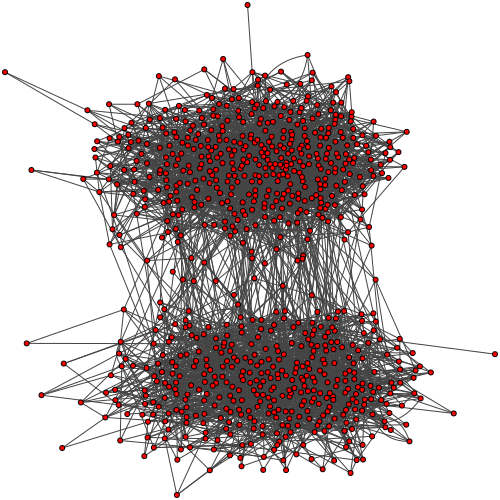

In [8]:
g.vs["size"] = 5
ig.plot(g, bbox=(500, 500), margin=5)


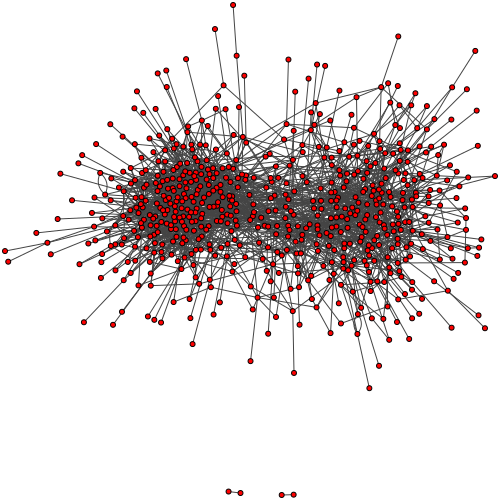

In [9]:
g_1.vs["size"] = 5
ig.plot(g_1, bbox=(500, 500), margin=5)

<Axes: xlabel='dim_0', ylabel='dim_1'>

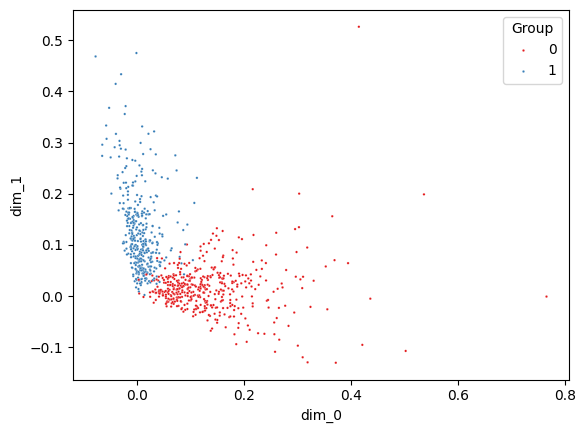

In [10]:
temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A0, 2), mode = "relu")
# temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A0, 10), softplus_parameter = 1)
latpos_0 = pd.DataFrame((temp.data @ temp.align_mat).numpy())

latpos_0 = latpos_0.rename(columns = {0: "dim_0", 1: "dim_1", 2: "dim_2"})
latpos_0["Graph_ID"] = latpos_0.index
latpos_0 = pd.merge(latpos_0, selected_players, how = "left", on = "Graph_ID")

sns.scatterplot(data = latpos_0, x = "dim_0", y = "dim_1", s = 3, hue = "Group", palette="Set1")

# fig = px.scatter_3d(data_frame = latpos_0, x = "dim_0", y = "dim_1", z = "dim_2", color = "Mean_MMR")
# fig.update_traces(marker = dict(size = 1))

<Axes: xlabel='0', ylabel='1'>

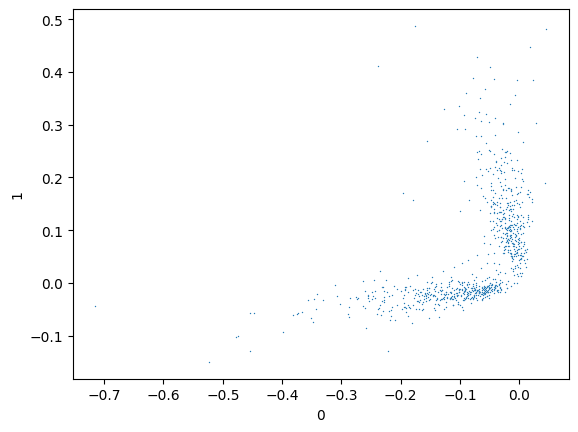

In [11]:
init_mat = Align.Oracle.ASE(A0, 2)
sns.scatterplot(pd.DataFrame(init_mat.detach().numpy()), x = 0, y = 1, s = 1)

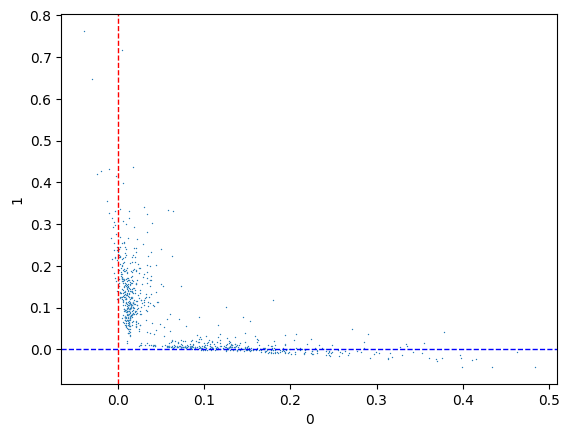

In [12]:
fitted_latpos = Align.GD_RDPG(A0, 1, init_mat, 5, 0.01, False)
# sns.scatterplot(pd.DataFrame(init_mat.detach().numpy()), x = 0, y = 1, s = 1)
sns.scatterplot(pd.DataFrame(fitted_latpos.fitted.detach().numpy()), x = 0, y = 1, s = 1)

# Add the lines
plt.axvline(x=0, color='red', linestyle='--', label='x = 0', linewidth = 1)
plt.axhline(y=0, color='blue', linestyle='--', label='y = 0', linewidth = 1)


144

<Axes: xlabel='dim_0', ylabel='dim_1'>

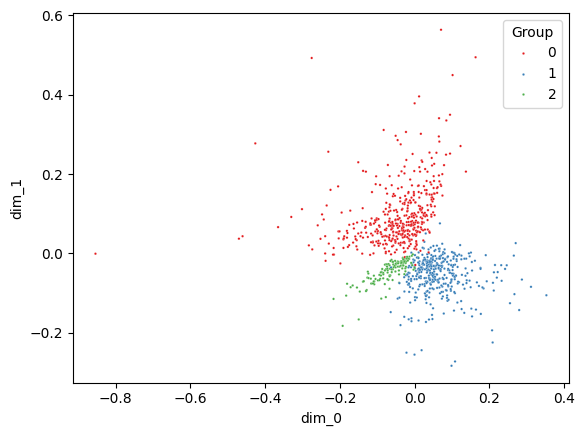

In [117]:
temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A1, 2), mode = "relu")
# temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A0, 10), softplus_parameter = 1)
latpos_1 = pd.DataFrame((temp.data @ temp.align_mat).numpy())

latpos_1 = latpos_1.rename(columns = {0: "dim_0", 1: "dim_1", 2: "dim_2"})
latpos_1["Graph_ID"] = latpos_1.index
latpos_1 = pd.merge(latpos_1, selected_players, how = "left", on = "Graph_ID")

sns.scatterplot(data = latpos_1, x = "dim_0", y = "dim_1", s = 3, hue = "Group", palette="Set1")

# fig = px.scatter_3d(data_frame = latpos_1, x = "dim_0", y = "dim_1", z = "dim_2", color = "Mean_MMR")
# fig.update_traces(marker = dict(size = 1))

In [4]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server"]]

temp = temp[temp["started_at"].between("2023-06-16", "2023-07-16")]
player_0_counts = temp["player_0"].value_counts()
player_1_counts = temp["player_1"].value_counts()
player_counts = player_0_counts.add(player_1_counts, fill_value = 0).astype(int)
player_counts = player_counts.reset_index()
player_counts.columns = ["Player_ID", "Match_Count"]

freq_player_wk_1 = player_counts[player_counts["Match_Count"] > 10]["Player_ID"].to_list()

freq_subset = temp[temp["player_0"].isin(freq_player_wk_1) & temp["player_1"].isin(freq_player_wk_1)]
freq_subset = freq_subset.loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(freq_subset, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)

A0 = torch.Tensor(g.get_adjacency().data)

In [36]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server"]]

temp = temp[temp["started_at"].between("2023-07-16", "2023-08-16")]
player_0_counts = temp["player_0"].value_counts()
player_1_counts = temp["player_1"].value_counts()
player_counts = player_0_counts.add(player_1_counts, fill_value = 0).astype(int)

player_counts = player_counts.reset_index()
player_counts.columns = ["Player_ID", "Match_Count"]

freq_player_wk_1 = player_counts[player_counts["Match_Count"] > 10]["Player_ID"].to_list()

freq_subset = temp[temp["player_0"].isin(freq_player_wk_1) & temp["player_1"].isin(freq_player_wk_1)]
freq_subset = freq_subset.loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(freq_subset, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)

A1 = torch.Tensor(g.get_adjacency().data)


In [2]:
class Op_Riemannian_GD:
    
    def __init__(self, data, initialization = None, mode = "softplus", softplus_parameter = 5, tolerance = 0.01):

        self.data = data
        self.tolerance = tolerance
        self.mode = mode
        self.initialization = initialization
        self.smoothing = softplus_parameter
        self.relu_loss = self.simplex_loss_relu(self.data)
        self.softplus_loss = self.simplex_loss_softplus(self.data, self.smoothing)
        self.align_mat = self.GD_Armijo()

    def update(self, mode = None, smoothing = None, tolerance = None):
        if mode is not None:
            self.mode = mode
        if smoothing is not None:
            self.smoothing = smoothing
        if tolerance is not None:
            self.tolerance = tolerance
        self.align_mat = self.GD_Armijo

    @staticmethod
    def simplex_loss_relu(data_set):

        X = data_set
        relu = torch.nn.ReLU()

        negativity_loss = torch.sum(relu(-X))

        row_sum_minus_1 = torch.sum(X, dim = 1) - 1
        simp_loss = torch.sum(relu(row_sum_minus_1))

        return(negativity_loss + simp_loss)
    
    @staticmethod
    def simplex_loss_softplus(data_set, smoothing):

        X = data_set
        mu = smoothing

        softplus = torch.nn.Softplus(beta = mu)

        negativity_loss = torch.sum(softplus(-X))

        row_sum_minus_1 = torch.sum(X, dim = 1) - 1
        simp_loss = torch.sum(softplus(row_sum_minus_1))

        return(negativity_loss + simp_loss)
    
    def deriv_W_relu(self, W):

        X = self.data
        n, p = X.shape

        signs_1 = (-X @ W > 0) * 1.
        deriv_neg = -X.T @ torch.relu(signs_1)

        sign_2 = ((torch.sum(X @ W,  dim = 1) - 1) > 0) * 1.
        deriv_simp = X.T @ torch.relu(sign_2.unsqueeze(dim = 1)) @ torch.ones((1,p))

        return(deriv_neg + deriv_simp)
    
    def deriv_W_softplus(self, W):

        X = self.data
        n, p = X.shape
        
        mu = self.smoothing

        T0 = torch.exp(-mu* X @ W)
        deriv_neg = -X.T @ (T0/(1 + T0))

        row_sum_minus_1 = torch.sum(X @ W, dim = 1) - 1

        T1 = torch.exp(mu * row_sum_minus_1.unsqueeze(dim = 1))
        deriv_simp = X.T @ (T1/(1 + T1)) @ torch.ones((1, p))

        return(deriv_neg + deriv_simp)
    
    def proj_skew_sym_at_W(self, M, W):

        projection = W @ (W.T @ M - M.T @ W)/2

        return(projection)

    def matrix_exp_at_W(self, xi, W):

        Exp_w_xi = W @ torch.matrix_exp(W.T @ xi)

        return(Exp_w_xi)
    
    def GD_one_step(self, prev_position, step):
        
        W_old = prev_position

        W_old = W_old * torch.sqrt(1/(W_old @ W_old.T)[0,0])
        
        if self.mode == "relu":
            euclid_deriv = self.deriv_W_relu(W_old)
        else:
            euclid_deriv = self.deriv_W_softplus(W_old)
        
        tangent_deriv = self.proj_skew_sym_at_W(euclid_deriv, W_old)

        W_new = self.matrix_exp_at_W(-step*tangent_deriv, W_old)
        
        return(W_new)
    
    def GD_Armijo(self):

        X = self.data
        n, p = X.shape

        if self.initialization is not None:
            W = self.initialization
        else: 
            W = torch.eye(p)

        if self.mode == "relu":
            grad = self.deriv_W_relu
            cost = self.simplex_loss_relu
        else:
            grad = self.deriv_W_softplus
            cost = partial(self.simplex_loss_softplus, smoothing = self.smoothing)
        
        b = 0.1; sigma = 0.1
        max_iter = 200 * p

        iter = 1
        go = True
        while go:
            
            t = 0.001
            k = 1
            while (cost(X @ self.GD_one_step(W, t)) > cost(X @ W) - sigma * t * torch.norm(grad(W))):
                t = t * (b**k)
                k += 1
                if k > 10:
                    break


            W = self.GD_one_step(W, t)
            jump = sigma * t * torch.norm(grad(W))

            go = (torch.norm(grad(W)) > self.tolerance) & (jump > 10e-8) & (iter < max_iter)
            iter += 1

        return(W)

In [ ]:
def GD_RDPG(A,X, L, tol=1e-3):

    n = A.shape[0]
    M = torch.ones(n, n) - torch.diag(torch.ones(n))
    M, A, X = M.to(device), A.to(device), X.to(device)

    X = X[:, :2]

    def gradient(A,X,M):

        gd = 2 * torch.matmul(( -torch.mul((M.T+M), (A)) + torch.mul((M.T+M), torch.matmul(X, X.T))), X)
        gd = gd + L*(-1)*(X < 0)
        # rowsum_X_ind = (torch.sum(X, axis = 1) > 1) * 1.0
        # gd = gd + 50*torch.cat([rowsum_X_ind.unsqueeze(0)] * 2, dim=0).T

        return gd
    
    def cost_function(A,X,M):

        cost = 0.5 * torch.norm((A - torch.matmul(X, X.T)) * M, p='fro')**2 
        cost = cost + L*torch.sum(-X[X<0])

        # rowsum_X = torch.sum(X, axis = 1)
        # cost = cost + 50*torch.sum(rowsum_X[rowsum_X > 1])

        cost = cost.to("cpu")
        torch.cuda.empty_cache()
        return cost


    b=0.3; sigma=0.1 # Armijo parameters
    rank = X.shape[1]
    max_iter = 200*rank
    t = 0.1
    Xd=X
    k=0
    last_jump=1
    d = -gradient(A,Xd,M)
    tol = tol*(torch.norm(d))
    while (torch.norm(d) > tol) & (last_jump > 1e-16) & (k<max_iter):

        # Armijo
        while (cost_function(A, Xd+t*d, M) > cost_function(A, Xd, M) - sigma*t*torch.norm(d)**2):
            t=b*t

        Xd = Xd+t*d
        last_jump = sigma*t*torch.norm(d)**2
        t=t/(b)
        k=k+1
        d = -gradient(A,Xd,M)

    Xd = Xd.to("cpu")
    del(M, A, X, d)
    torch.cuda.empty_cache()

    last_dim = 1 - torch.sum(Xd, axis = 1).unsqueeze(1)
    aligned_ASE_full = torch.cat((Xd, last_dim), dim = 1)

    return(aligned_ASE_full) 